## GCM Capstone - Missing Data EDA

## *Lingzhen Zhu*

**Feb 25, 2024**

In [37]:
import polars as pl
import matplotlib.pyplot as plt
import numpy as np

In [98]:
df = pl.read_csv('mdex_cgm_plus_features.csv')

In [99]:
df = df.select(pl.col('SID', 'Day', 'Hour', 'Min', 'DT_Index', 'DailyTI_Index', 'StudyTI_Index', 'Value'))

In [100]:
df = df.with_columns(pl.col("DT_Index").str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S"))

In [101]:
df.schema

OrderedDict([('SID', String),
             ('Day', Int64),
             ('Hour', Int64),
             ('Min', Int64),
             ('DT_Index', Datetime(time_unit='us', time_zone=None)),
             ('DailyTI_Index', Int64),
             ('StudyTI_Index', Int64),
             ('Value', Float64)])

In [104]:
df = df.with_columns(
    pl.when(pl.col("StudyTI_Index").diff() < 0)
    .then(0)
    .otherwise(pl.col("StudyTI_Index").diff())
    .alias("diff")
)
df = df.with_columns((pl.col("diff") - 1).fill_null(pl.lit(0)).alias("missing_counts"))

* Patterns of distribution of missing data throughout the day

In [106]:
def classify_hour(hour):
    if hour < 6:
        return "Sleeping"
    elif hour < 9:
        return "Breakfast Time"
    elif hour < 11:
        return "Morning Time"
    elif hour < 14:
        return "Lunch Time"
    elif hour < 17:
        return "Afternoon Time"
    elif hour < 20:
        return "Dinner Time"
    else:
        return "Evening Time"
df = df.with_columns(pl.col("Hour").map_elements(classify_hour).alias("Time_Segment"))
time_segment_distribution = df.filter(pl.col("missing_counts") >= 1).group_by("Time_Segment").agg(pl.len().alias("Count"))

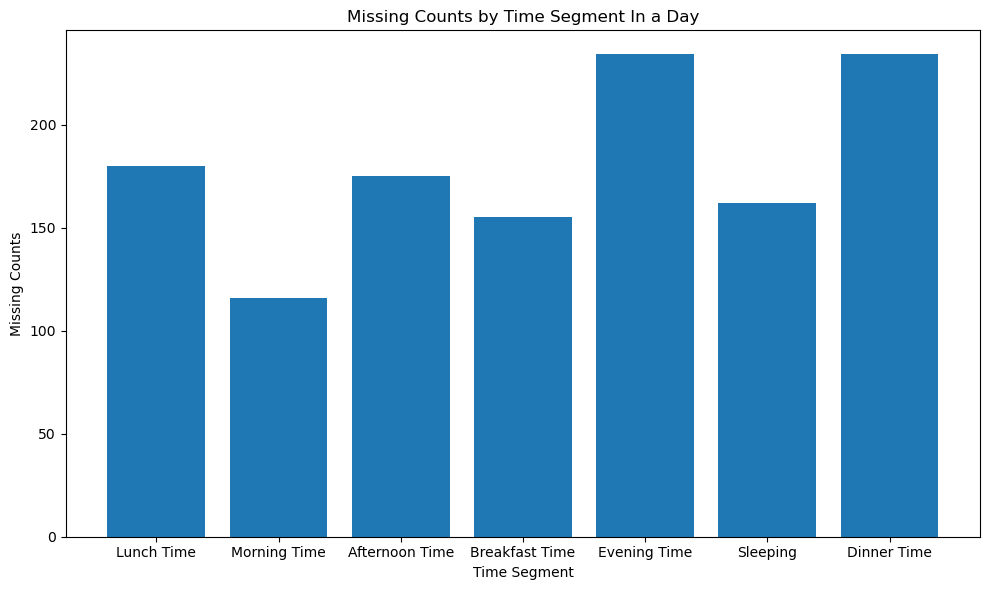

In [107]:
plt.figure(figsize=(10, 6))
plt.bar(x=time_segment_distribution['Time_Segment'], height=time_segment_distribution['Count'])
plt.title('Missing Counts by Time Segment In a Day')
plt.xlabel('Time Segment')
plt.ylabel('Missing Counts')
plt.tight_layout()
plt.show()

* Patterns of distribution of missing data throughout the patient

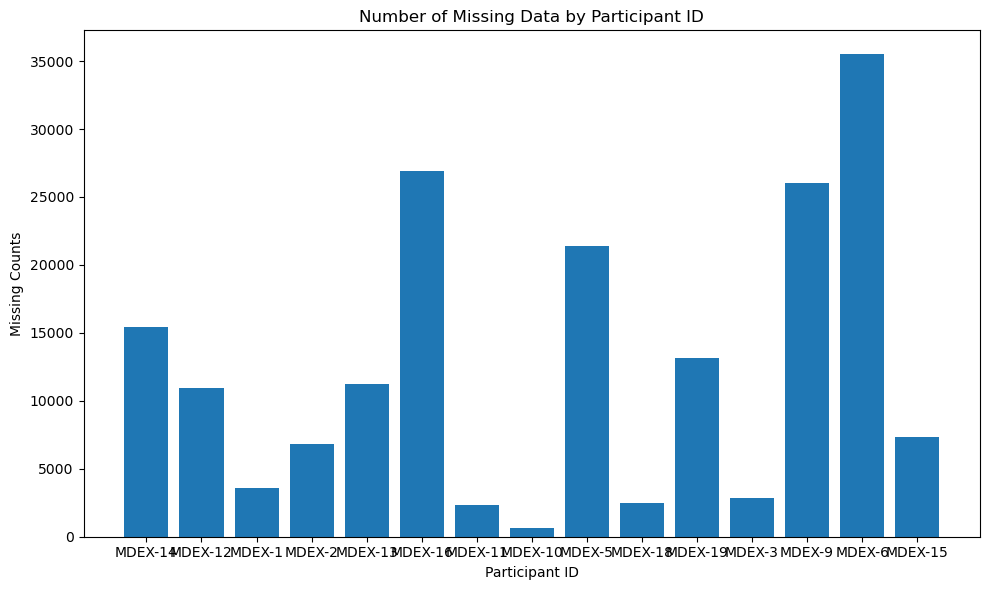

In [109]:
participant_missing = df.group_by("SID").agg(pl.sum("missing_counts"))


plt.figure(figsize=(10, 6))
plt.bar(x=participant_missing['SID'], height=participant_missing['missing_counts'])
plt.title('Number of Missing Data by Participant ID')
plt.xlabel('Participant ID')
plt.ylabel('Missing Counts')
plt.tight_layout()
plt.show()

* Analyzing the length frequency distribution of missing data

In [120]:
def classify_length(count):
    if count < 5:
        return "less than 20 min"
    elif count < 9:
        return "20-40 min"
    elif count < 13:
        return "40-60 min"
    elif count < 25:
        return "1-2 hours"
    elif count < 49:
        return "2-4 hours"
    else:
        return "more than 4 hours"
df = df.with_columns(pl.col("missing_counts").map_elements(classify_length).alias("Time_Length"))
length_distribution = df.filter(pl.col("missing_counts") >= 1).group_by("Time_Length").agg(pl.len().alias("Count"))

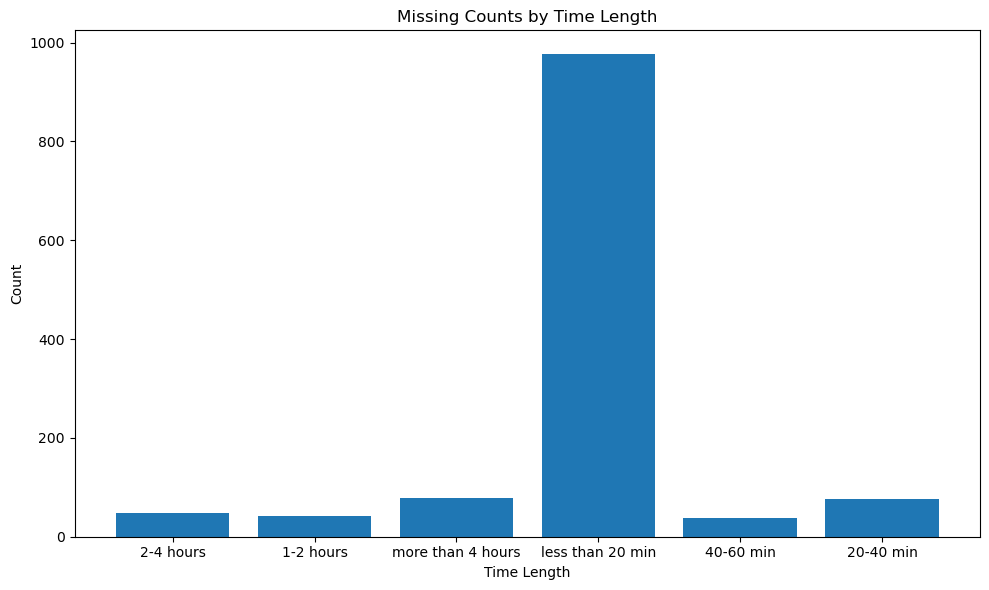

In [116]:
plt.figure(figsize=(10, 6))
plt.bar(x=length_distribution['Time_Length'], height=length_distribution['Count'])
plt.title('Missing Counts by Time Length')
plt.xlabel('Time Length')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [135]:
length_distribution1 = length_distribution.filter(pl.col("Time_Length") != "less than 20 min")

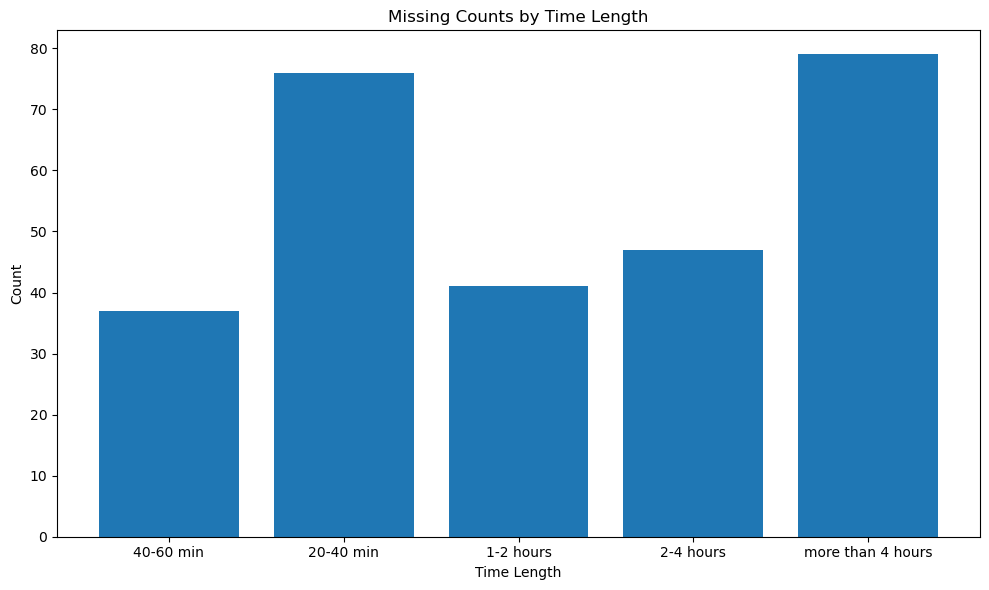

In [140]:
plt.figure(figsize=(10, 6))
plt.bar(x=length_distribution1['Time_Length'], height=length_distribution1['Count'])
plt.title('Missing Counts by Time Length')
plt.xlabel('Time Length')
plt.ylabel('Count')
plt.tight_layout()
plt.show()